

# <font color= #3194ce > Log Rank test and Kaplan Meier curvs
------

In [2]:
import sys
sys.path.insert(0, '/home/labs/hornsteinlab/hadarkl/Hadar/primals/code')
import pandas as pd
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
from lifelines import KaplanMeierFitter, NelsonAalenFitter
from lifelines.statistics import logrank_test
from statsmodels.stats.multitest import multipletests


#---------------------------------------------------------------------------
#loaders
%load_ext autoreload
%autoreload 2

from utils.survival_plots import find_best_shared_split_and_plot_km

## 📎 <font color=#CE6B31>Load Data 

### Proteomic

- log before combat 
- low corr data(remove r < 0.7)
- no missing values
- clinical data (Survival_from_onset (months), Status dead=1, Age Onset ,ALSFRS score,ALSFRS_slope)

In [95]:
discovery = pd.read_csv('/home/labs/hornsteinlab/hadarkl/Hadar/primals/code/data/raw_data/proteins/DIANN/COMBAT/log_before_combat_discovery_low_collinearity.csv')
discovery= discovery.rename(columns={'sample_number': 'sample number'})
discovery = discovery.set_index('sample number')
replication = pd.read_csv('/home/labs/hornsteinlab/hadarkl/Hadar/primals/code/data/raw_data/proteins/DIANN/COMBAT/log_before_combat_replication_low_collinearity.csv')
replication= replication.rename(columns={'sample_number': 'sample number'})
replication = replication.set_index('sample number')


### clinical 

In [96]:
clinical_discovery = pd.read_csv('/home/labs/hornsteinlab/Collaboration/PRIMALS/Serum/Hadar/primals/code/data/raw_data/clinical_data/clinical_data_discovery.csv')
clinical_discovery = clinical_discovery[['sample number','Survival_from_onset (months)','Status dead=1']]
#clinical_dis =clinical_dis.set_index('sample number')
clinical_replication = pd.read_csv('/home/labs/hornsteinlab/Collaboration/PRIMALS/Serum/Hadar/primals/code/data/raw_data/clinical_data/clinical_data_replication.csv')
clinical_replication= clinical_replication[['sample number','Survival_from_onset (months)','Status dead=1']]
#clinical_rep = clinical_rep.set_index('sample number')

### Merge

In [97]:
df_discovery_merge = pd.merge(discovery, clinical_discovery, on='sample number', how='left')
df_discovery_merge = df_discovery_merge.set_index('sample number')
df_replication_merge = pd.merge(replication, clinical_replication, on='sample number', how='left')
df_replication_merge = df_replication_merge.set_index('sample number')

-------------

## <font color ='#CE6B31'> KM curve with Best split point 
- Only for the significant replicat proteins from cox univariate 

### **LRG1**

INFO:root:Processing protein: LRG1


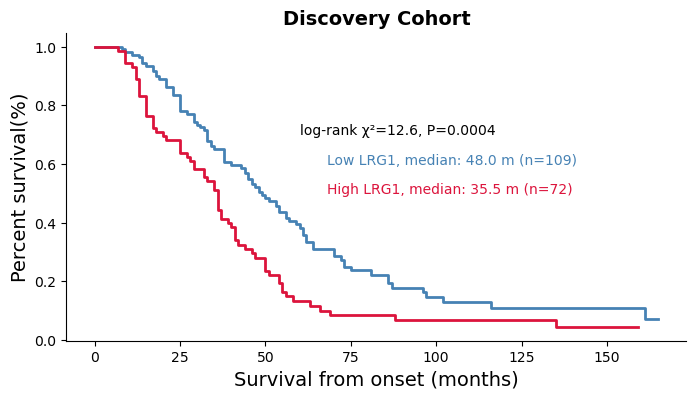

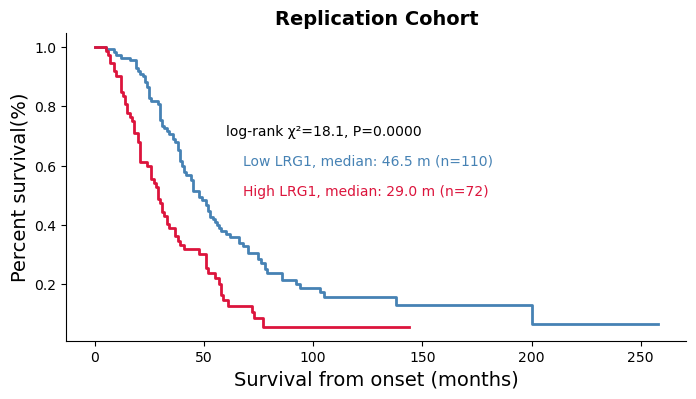

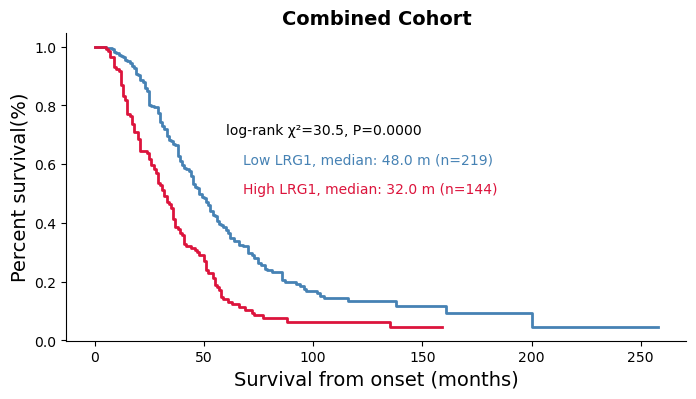

In [18]:
results = find_best_shared_split_and_plot_km(
    df_discovery_merge, df_replication_merge, 
    proteins=["LRG1"],
    time_col="Survival_from_onset (months)", 
    event_col="Status dead=1",
    min_samples=70 #min sampple in each group 
)




### **IGDCC4**

INFO:root:Processing protein: IGDCC4


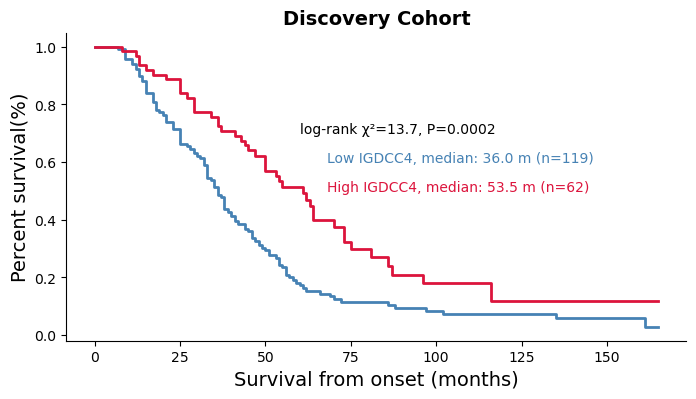

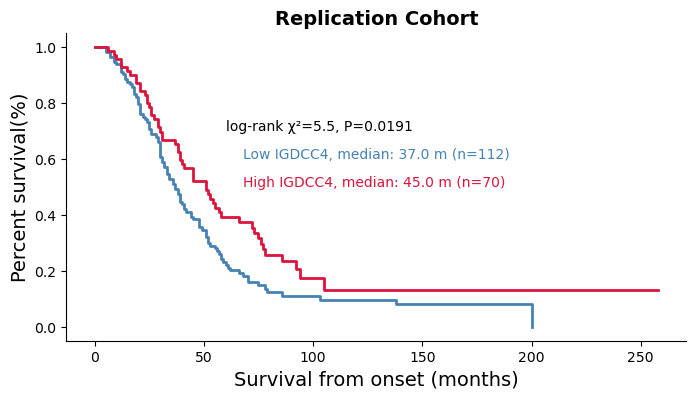

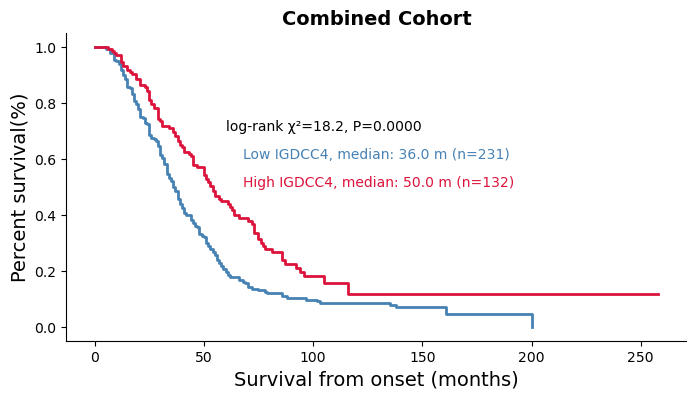

In [19]:
results = find_best_shared_split_and_plot_km(
    df_discovery_merge, df_replication_merge, 
    proteins=["IGDCC4"],
    time_col="Survival_from_onset (months)", 
    event_col="Status dead=1",
    min_samples=40 #min sampple in each group 
)




### **IGFBP2**

INFO:root:Processing protein: IGFBP2


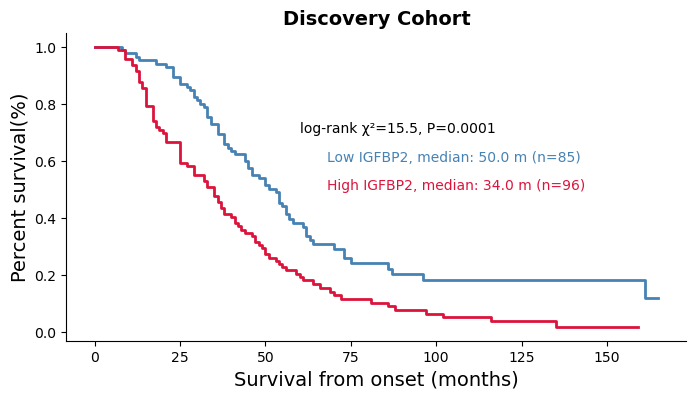

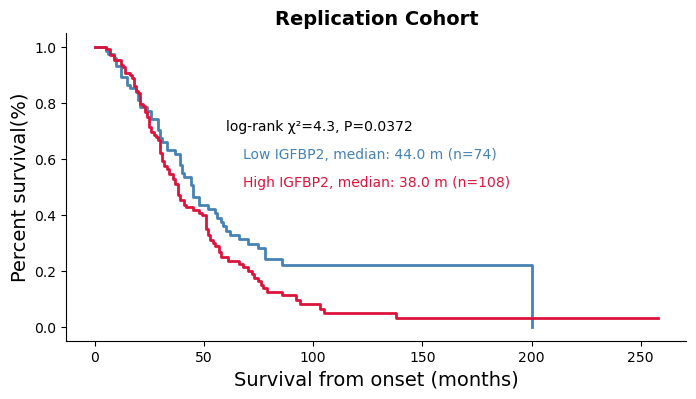

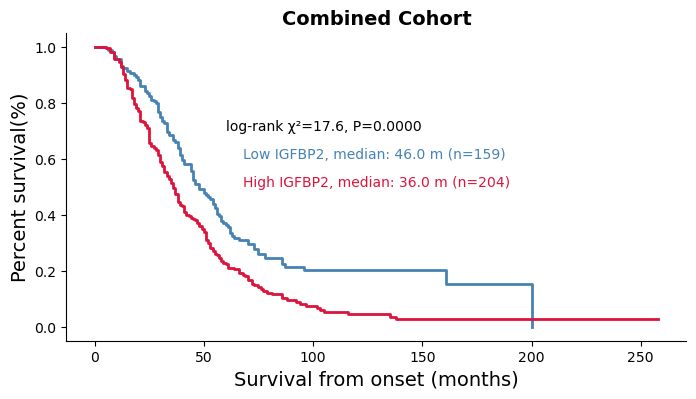

In [21]:
results = find_best_shared_split_and_plot_km(
    df_discovery_merge, df_replication_merge, 
    proteins=["IGFBP2"],
    time_col="Survival_from_onset (months)", 
    event_col="Status dead=1",
    min_samples=50 #min sampple in each group 
)




## <font color ='#CE6B31'> KM curve with Median

In [9]:
median_discovery = df_discovery_merge['LRG1'].median()
median_discovery

30.5641817962889

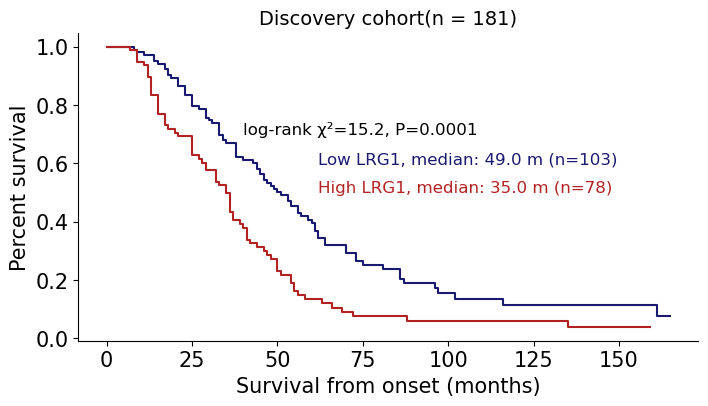

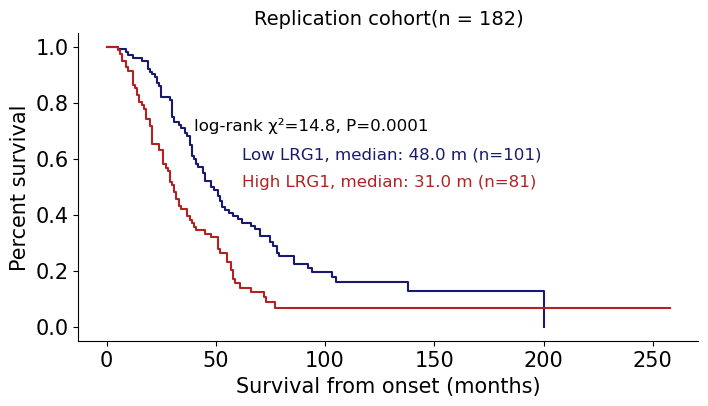

In [10]:

# Use median from Discovery Cohort to split groups
median_discovery =30.609349	
#median_discovery =30.6541817962889
df_dis_low = df_discovery_merge[df_discovery_merge['LRG1'] <= median_discovery]
df_dis_high = df_discovery_merge[df_discovery_merge['LRG1'] > median_discovery]
df_rep_low = df_replication_merge[df_replication_merge['LRG1'] <= median_discovery]
df_rep_high = df_replication_merge[df_replication_merge['LRG1'] > median_discovery]


 
# Function to plot KM curve
def plot_km_curve(kmf_low, kmf_high, df_low, df_high, title, logrank):
    plt.figure(figsize=(8, 4))
    kmf_low.plot(ci_show=False, linewidth=1.5, color='midnightblue')
    kmf_high.plot(ci_show=False, linewidth=1.5, color='firebrick')
    
    # Remove default legend
    plt.gca().get_legend().remove()
    
    # # Add Log-Rank statistics and median survival values next to the curves
    #plt.text(40, 0.7, f'HR=1.5, P={logrank.p_value:.4f}', fontsize=12)
    plt.text(40, 0.7, f'log-rank χ²={logrank.test_statistic:.1f}, P={logrank.p_value:.4f}', fontsize=12)

    # plt.text(62, 0.6, f'Low LRG1, median: {df_low["Survival_from_onset (months)"].median():.1f} m', fontsize=12, color='midnightblue')
    # plt.text(62, 0.5, f'High LRG1, median: {df_high["Survival_from_onset (months)"].median():.1f} m', fontsize=12, color='firebrick')
    #  # Add median survival information
    plt.text(62, 0.6, f'Low LRG1, median: {df_low["Survival_from_onset (months)"].median():.1f} m (n={len(df_low)})', 
             fontsize=12, color='midnightblue')
    plt.text(62, 0.5, f'High LRG1, median: {df_high["Survival_from_onset (months)"].median():.1f} m (n={len(df_high)})', 
             fontsize=12, color='firebrick')
    
    plt.xlabel("Survival from onset (months)", size = 15)
    plt.ylabel("Percent survival",size = 15)
    plt.xticks(size = 15)
    plt.yticks(size = 15)
    
    #plt.grid(False, linestyle='--', alpha=0.7)
    plt.title(title, fontsize=14)
    sns.despine(top=True, right=True, left=False, bottom=False)

    plt.show()

# Fit KM models
kmf_dis_low, kmf_dis_high = KaplanMeierFitter(), KaplanMeierFitter()
kmf_rep_low, kmf_rep_high = KaplanMeierFitter(), KaplanMeierFitter()
kmf_dis_low.fit(df_dis_low['Survival_from_onset (months)'], event_observed=df_dis_low['Status dead=1'])
kmf_dis_high.fit(df_dis_high['Survival_from_onset (months)'], event_observed=df_dis_high['Status dead=1'])
kmf_rep_low.fit(df_rep_low['Survival_from_onset (months)'], event_observed=df_rep_low['Status dead=1'])
kmf_rep_high.fit(df_rep_high['Survival_from_onset (months)'], event_observed=df_rep_high['Status dead=1'])

# Perform Log-Rank Tests
logrank_dis = logrank_test(df_dis_low['Survival_from_onset (months)'], df_dis_high['Survival_from_onset (months)'],
                           event_observed_A=df_dis_low['Status dead=1'], event_observed_B=df_dis_high['Status dead=1'])
logrank_rep = logrank_test(df_rep_low['Survival_from_onset (months)'], df_rep_high['Survival_from_onset (months)'],
                           event_observed_A=df_rep_low['Status dead=1'], event_observed_B=df_rep_high['Status dead=1'])

# Plot Discovery and Replication Cohorts
plot_km_curve(kmf_dis_low, kmf_dis_high, df_dis_low, df_dis_high, "Discovery cohort(n = 181)", logrank_dis)
plot_km_curve(kmf_rep_low, kmf_rep_high, df_rep_low, df_rep_high, "Replication cohort(n = 182)", logrank_rep)

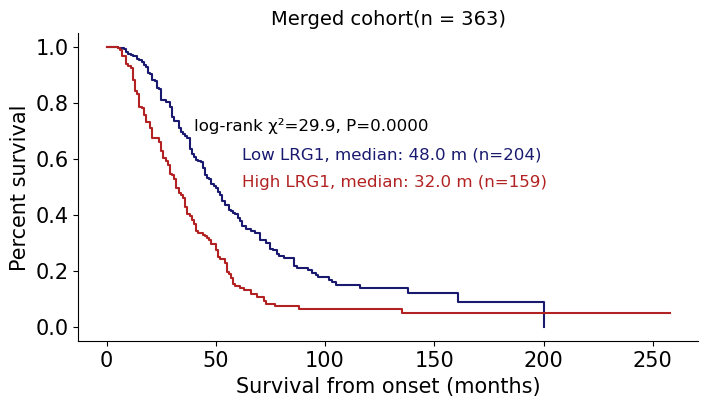

In [11]:
# Combine Both Cohorts
df_combined = pd.concat([df_replication_merge, df_discovery_merge])
df_comb_low = df_combined[df_combined['LRG1'] <= median_discovery]
df_comb_high = df_combined[df_combined['LRG1'] > median_discovery]
kmf_comb_low, kmf_comb_high = KaplanMeierFitter(), KaplanMeierFitter()
kmf_comb_low.fit(df_comb_low['Survival_from_onset (months)'], event_observed=df_comb_low['Status dead=1'])
kmf_comb_high.fit(df_comb_high['Survival_from_onset (months)'], event_observed=df_comb_high['Status dead=1'])

# Log-Rank Test for Combined Cohort
logrank_comb = logrank_test(df_comb_low['Survival_from_onset (months)'], df_comb_high['Survival_from_onset (months)'],
                            event_observed_A=df_comb_low['Status dead=1'], event_observed_B=df_comb_high['Status dead=1'])

# Plot Combined Cohort
plot_km_curve(kmf_comb_low, kmf_comb_high, df_comb_low, df_comb_high, "Merged cohort(n = 363)", logrank_comb)


## <font color ='#CE6B31'> log rank test
- All the data
- Based on median
- show only proteins that also significant after FDR in replication cohort.

### Discovery:

In [129]:

duration_col = "Survival_from_onset (months)"
event_col = "Status dead=1"
# ------------------------------
# Run Log-Rank Tests
protein_columns = [col for col in df_discovery_merge.columns if col not in [duration_col, event_col]]

logrank_results_discovery = []

for protein in protein_columns:
    median_value = df_discovery_merge[protein].median()
    df_low = df_discovery_merge[df_discovery_merge[protein] < median_value]
    df_high = df_discovery_merge[df_discovery_merge[protein] >= median_value]

    try:
        logrank_result = logrank_test(
            df_low[duration_col], df_high[duration_col],
            event_observed_A=df_low[event_col], event_observed_B=df_high[event_col]
        )
        p_val = logrank_result.p_value
        stat = logrank_result.test_statistic
    except:
        p_val = np.nan
        stat = np.nan

    logrank_results_discovery.append({
        "Protein": protein,
        "p_value": p_val,
        "statistic": stat,
        "median": median_value
    })

df_logrank_discovery = pd.DataFrame(logrank_results_discovery)

# Drop NaNs and sort by p-value ascending
df_logrank_discovery_clean = df_logrank_discovery.dropna(subset=["p_value"]).sort_values(by="p_value", ascending=True).copy()

# Apply FDR Correction
df_logrank_discovery_clean["FDR_adjusted_pval"] = multipletests(df_logrank_discovery_clean["p_value"], method="fdr_bh")[1]

# ------------------------------
# Filter Significant Proteins
significant_proteins_discovery_fdr = df_logrank_discovery_clean[df_logrank_discovery_clean["FDR_adjusted_pval"] <= 0.05].copy()

# ------------------------------
# Summary Output
if significant_proteins_discovery_fdr.empty:
    print("⚠️ No proteins passed FDR correction in the discovery cohort.")
else:
    print(f"{len(significant_proteins_discovery_fdr)} proteins passed FDR < 0.05 in discovery.")
    display(significant_proteins_discovery_fdr[["Protein", "p_value", "FDR_adjusted_pval"]])


20 proteins passed FDR < 0.05 in discovery.


,Protein,p_value,FDR_adjusted_pval
1225,VSIG4,1.907695e-07,0.000216
409,EXTL2,2.156054e-05,0.012203
401,EPHB4,4.560661e-05,0.015380
251,CILP2,5.434743e-05,0.015380
996,REG1A,8.953524e-05,0.018720
694,LRG1,9.922276e-05,0.018720
452,FGB,1.187307e-04,0.018797
19,ADAM15,1.331858e-04,0.018797
527,GRN,1.568183e-04,0.018797
600,IGFBP2,1.949952e-04,0.018797


### Replication :

In [130]:

# Subset replication dataset
# ---------------------------------
SIGNIFICANT_DISCOVERY_PROTEINS = significant_proteins_discovery_fdr['Protein'].to_list()
columns_to_keep = SIGNIFICANT_DISCOVERY_PROTEINS + ['Survival_from_onset (months)', 'Status dead=1']
df_replication_subset = df_replication_merge[columns_to_keep].copy()
# ---------------------------------
duration_col = "Survival_from_onset (months)"
event_col = "Status dead=1"
protein_columns = [col for col in df_replication_subset.columns if col not in [duration_col, event_col]]

# ---------------------------------
# Run Log-Rank Tests
logrank_results_replication = []

for protein in protein_columns:
    median_value = df_replication_subset[protein].median()
    df_low = df_replication_subset[df_replication_subset[protein] < median_value]
    df_high = df_replication_subset[df_replication_subset[protein] >= median_value]

    try:
        logrank_result = logrank_test(
            df_low[duration_col], df_high[duration_col],
            event_observed_A=df_low[event_col], event_observed_B=df_high[event_col]
        )
        p_val = logrank_result.p_value
        stat = logrank_result.test_statistic
    except:
        p_val = np.nan
        stat = np.nan

    logrank_results_replication.append({
        "Protein": protein,
        "p_value": p_val,
        "statistic": stat,
        "median": median_value
    })

df_logrank_replication = pd.DataFrame(logrank_results_replication).dropna(subset=["p_value"])

# Keep only proteins with raw p < 0.05
significant_proteins_replication = df_logrank_replication[df_logrank_replication["p_value"] <= 0.05].copy()

if significant_proteins_replication.empty:
    print("⚠️ No proteins were significant (p < 0.05) in the replication cohort.")
else:
    print(f"{len(significant_proteins_replication)} proteins were significant in replication (p < 0.05).")
    display(significant_proteins_replication[["Protein", "p_value"]].sort_values("p_value"))


4 proteins were significant in replication (p < 0.05).


,Protein,p_value
5,LRG1,0.004519
19,LGALS3,0.012393
1,EXTL2,0.015678
8,GRN,0.034297


## <font color ='#CE6B31'> Bubble plot

In [131]:
# Merge only shared significant proteins
merged_results = significant_proteins_discovery_fdr.merge(
    significant_proteins_replication,
    on="Protein",
    suffixes=("_discovery", "_replication")
)

# Calculate -log10(p) for size encoding
merged_results["log_p_discovery"] = -np.log10(merged_results["p_value_discovery"])
merged_results["log_p_replication"] = -np.log10(merged_results["p_value_replication"])


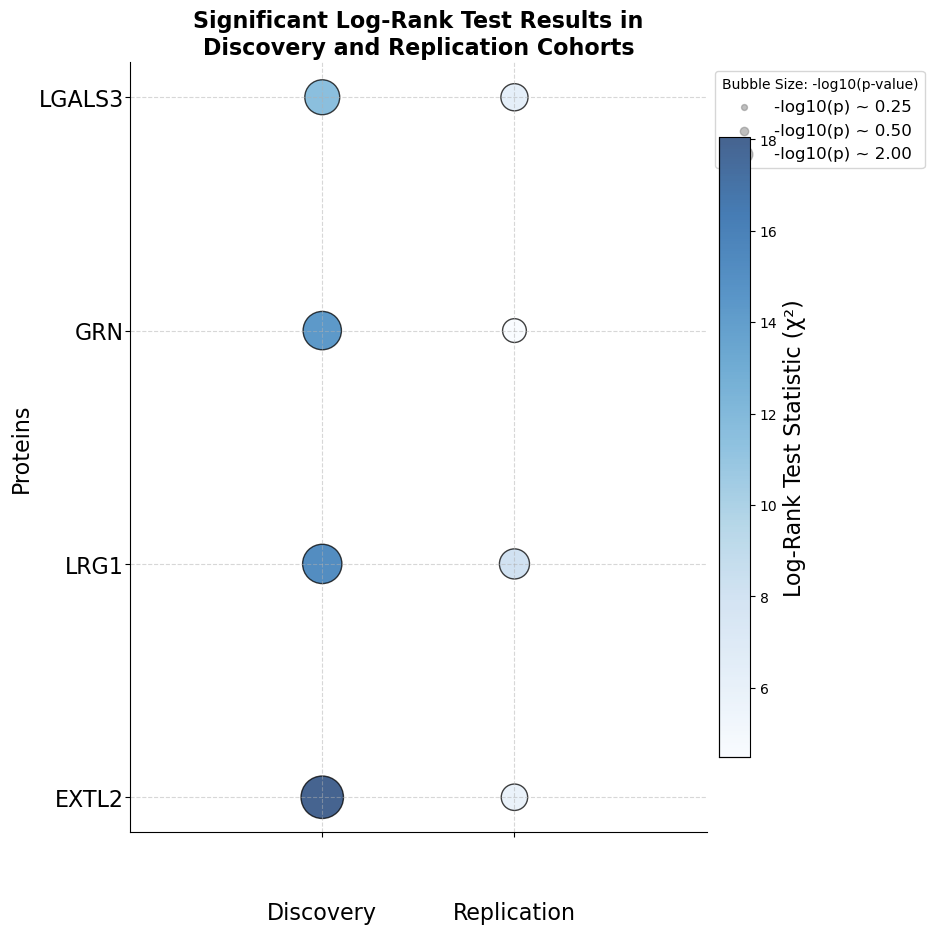

In [135]:
# Re-import list from built-in functions (manual fix)

del list
list = __builtins__.list


# Step 1: Merge significant proteins from both cohorts
merged_results = significant_proteins_discovery_fdr.merge(
    significant_proteins_replication,
    on="Protein",
    suffixes=("_discovery", "_replication")
)

# Step 2: Calculate -log10(p) values
merged_results["log_p_discovery"] = -np.log10(merged_results["p_value_discovery"])
merged_results["log_p_replication"] = -np.log10(merged_results["p_value_replication"])

# Step 3: Plot
fig, ax = plt.subplots(figsize=(8, 10))

x_labels = ["Replication"] * len(merged_results) + ["Discovery"] * len(merged_results)
y_labels = list(merged_results["Protein"]) + list(merged_results["Protein"])
y_positions = list(np.arange(len(merged_results))) + list(np.arange(len(merged_results)))

bubble_size = list(merged_results["log_p_replication"] * 200) + list(merged_results["log_p_discovery"] * 200)
bubble_color = list(merged_results["statistic_replication"]) + list(merged_results["statistic_discovery"])

# Create scatter plot
scatter = ax.scatter(
    x_labels, y_positions, s=bubble_size, c=bubble_color, cmap="Blues",
    edgecolors="black", alpha=0.75
)

# Set y-axis
ax.set_yticks(np.arange(len(merged_results)))
ax.set_yticklabels(merged_results["Protein"], fontsize=12)
ax.yaxis.set_tick_params(pad=1)
ax.xaxis.set_tick_params(pad=46)

# Add color bar
cbar = plt.colorbar(scatter, ax=ax, pad=0.02, fraction=0.05, shrink=0.9)
cbar.set_label("Log-Rank Test Statistic (χ²)", fontsize=16)

# Add legend for bubble size
legend_sizes = [50, 100, 400]
for size in legend_sizes:
    ax.scatter([], [], s=size, color="gray", alpha=0.5, label=f'-log10(p) ~ {size/200:.2f}')
ax.legend(title="Bubble Size: -log10(p-value)", fontsize=12, markerscale=0.6, loc="upper left", bbox_to_anchor=(1, 1))

# Labels and formatting
ax.set_ylabel("Proteins", fontsize=16)
ax.set_xticks([0, 1])
ax.set_xticklabels(["Replication", "Discovery"], fontsize=16)
plt.xlim(2, -1)
ax.set_title('Significant Log-Rank Test Results in\nDiscovery and Replication Cohorts', fontsize=16, fontweight="bold")

sns.despine(top=True, right=True, left=False, bottom=False)
plt.yticks(size=16)
ax.grid(True, linestyle="--", alpha=0.5)

# Show
plt.show()


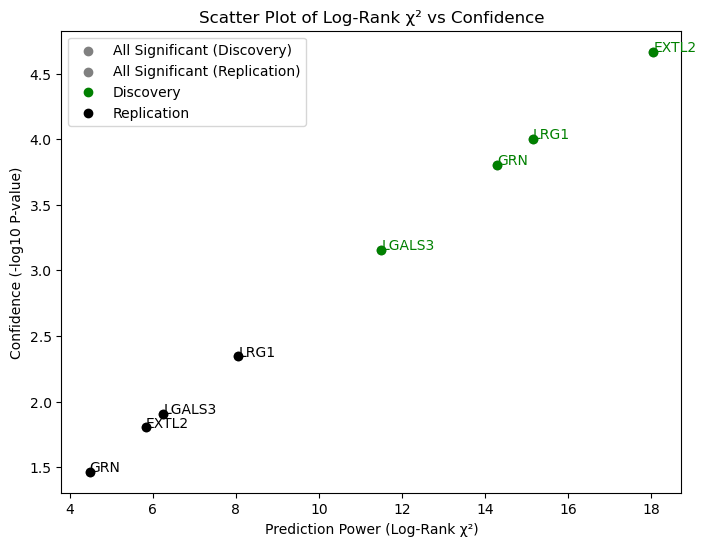

In [120]:
# Create Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(merged_results["statistic_discovery"], merged_results["log_p_discovery"], color="grey", label="All Significant (Discovery)")
plt.scatter(merged_results["statistic_replication"], merged_results["log_p_replication"], color="grey", label="All Significant (Replication)")

# Highlight Top 2 in Discovery (Green) and Top 2 in Replication (Black)
top2_discovery = merged_results.nsmallest(5, "p_value_discovery")
top2_replication = merged_results.nsmallest(5, "p_value_replication")

plt.scatter(top2_discovery["statistic_discovery"], top2_discovery["log_p_discovery"], color="green", label="Discovery")
plt.scatter(top2_replication["statistic_replication"], top2_replication["log_p_replication"], color="black", label="Replication")

# Label Points
for i, row in top2_discovery.iterrows():
    plt.text(row["statistic_discovery"], row["log_p_discovery"], row["Protein"], fontsize=10, color="green")

for i, row in top2_replication.iterrows():
    plt.text(row["statistic_replication"], row["log_p_replication"], row["Protein"], fontsize=10, color="black")

plt.xlabel("Prediction Power (Log-Rank χ²)")
plt.ylabel("Confidence (-log10 P-value)")
plt.title("Scatter Plot of Log-Rank χ² vs Confidence")
plt.legend()
plt.show()


## <font color ='#CE6B31'> Nelson-Aalen estimator, which sums the risk contributions over time. The function increases only at times when an event (death)
- Steep incline (more frequent jumps) → Higher risk accumulation, meaning deaths are occurring rapidly.
- Gradual incline (slower jumps) → Lower risk accumulation, meaning patients are surviving longer.
- Gaps between steps → Periods where no events occurred, meaning patients in that group were still alive.

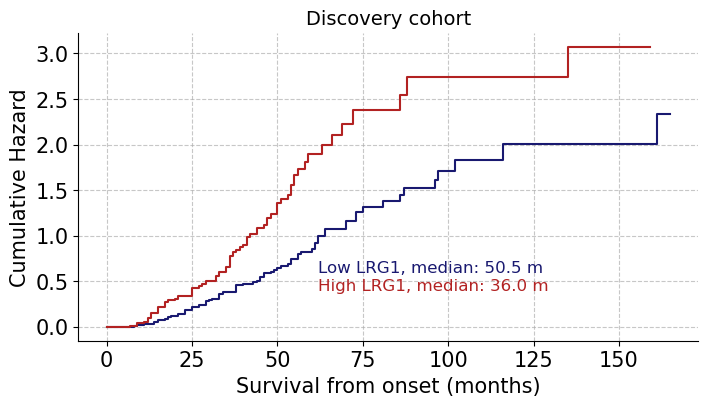

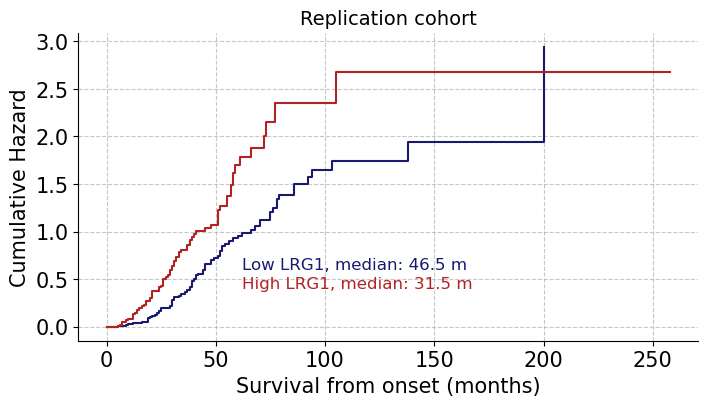

In [136]:

# Use the same median threshold from df_replication_merge
median = df_discovery_merge["LRG1"].median()

# Split df_replication_merge into two groups based on IGDCC4 median
df_disc_low = df_discovery_merge[df_discovery_merge["LRG1"] < median]
df_disc_high = df_discovery_merge[df_discovery_merge["LRG1"] >= median]

# Split df_discovery_merge using the same threshold
df_rep_low = df_replication_merge[df_replication_merge["LRG1"] < median]
df_rep_high = df_replication_merge[df_replication_merge["LRG1"] >= median]

# Initialize Nelson-Aalen Fitter
naf_rep_low = NelsonAalenFitter()
naf_rep_high = NelsonAalenFitter()
naf_disc_low = NelsonAalenFitter()
naf_disc_high = NelsonAalenFitter()

# Fit cumulative hazard models for both cohorts
naf_rep_low.fit(df_rep_low["Survival_from_onset (months)"], event_observed=df_rep_low["Status dead=1"])
naf_rep_high.fit(df_rep_high["Survival_from_onset (months)"], event_observed=df_rep_high["Status dead=1"])
naf_disc_low.fit(df_disc_low["Survival_from_onset (months)"], event_observed=df_disc_low["Status dead=1"])
naf_disc_high.fit(df_disc_high["Survival_from_onset (months)"], event_observed=df_disc_high["Status dead=1"])

# Create a function for consistent formatting
def plot_cumulative_hazard(naf_low, naf_high, df_low, df_high, title):
    plt.figure(figsize=(8, 4))
    
    # Plot cumulative hazard curves
    naf_low.plot(ci_show=False, linewidth=1.5, color='midnightblue')
    naf_high.plot(ci_show=False, linewidth=1.5, color='firebrick')
    
    # Remove default legend
    plt.gca().get_legend().remove()
    
    # Add median survival values near the curves
    plt.text(62, 0.6, f'Low LRG1, median: {df_low["Survival_from_onset (months)"].median():.1f} m', fontsize=12, color='midnightblue')
    plt.text(62, 0.4, f'High LRG1, median: {df_high["Survival_from_onset (months)"].median():.1f} m', fontsize=12, color='firebrick')
    
    # Formatting
    plt.xlabel("Survival from onset (months)", size=15)
    plt.ylabel("Cumulative Hazard", size=15)
    plt.xticks(size=15)
    plt.yticks(size=15)
    
    plt.title(title, fontsize=14)
    sns.despine(top=True, right=True, left=False, bottom=False)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.show()

# Plot for Discovery Cohort
plot_cumulative_hazard(naf_disc_low, naf_disc_high, df_disc_low, df_disc_high, "Discovery cohort")

# Plot for Replication Cohort
plot_cumulative_hazard(naf_rep_low, naf_rep_high, df_rep_low, df_rep_high, "Replication cohort")
